Fast Gradient Sign Attack


$\mathbf{x} + \epsilon \text{sign}(\nabla_{\mathbf{x}} J(\theta, \mathbf{x}, y))$

In [11]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils import data

In [5]:
def get_dataloader_workers():
    return 4

In [6]:
def load_data_mnist(batch_size):
    trans = [transforms.ToTensor()]
    trans = transforms.Compose(trans)
    
    mnist_train = torchvision.datasets.MNIST(
        root="./data", train=True, transform=trans, download=True
    )
    mnist_test = torchvision.datasets.MNIST(
        root="./data", train=False, transform=trans, download=True
    )
    
    train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                                 num_workers = get_dataloader_workers())
    test_iter = data.DataLoader(mnist_test, batch_size, shuffle=True,
                                 num_workers = get_dataloader_workers())
    
    return train_iter, test_iter

In [7]:
train_iter, test_iter = load_data_mnist(batch_size = 1)

In [29]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [30]:
model = Net()
model.load_state_dict(torch.load('lenet_mnist_model.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [31]:
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [32]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

In [52]:
for X, y in test_iter:
    X.requires_grad = True
    y_hat = model(X)
    _, predict = torch.max(y_hat.data, 1)
    if predict.item() != y:
            continue
    loss = F.nll_loss(y_hat, y)

    model.zero_grad()

    loss.backward()

    data_grad = X.grad.data
    print(data_grad)
    sign_data_grad = data_grad.sign()
    print(sign_data_grad)
    perturbed_X = X + 0.05 * sign_data_grad
    break

tensor([[[[ 7.6379e-05, -2.6148e-05,  1.1687e-04,  1.2768e-04,  5.2454e-05,
           -6.0014e-04,  1.3314e-03, -9.0396e-05,  3.0003e-04,  5.1065e-04,
            1.5580e-03,  1.8092e-03,  2.2059e-03,  3.4557e-05,  4.1404e-04,
            2.4641e-04,  3.5160e-04, -1.6731e-04,  1.0591e-03,  6.0011e-04,
            1.1853e-03, -4.0790e-04, -3.7630e-04, -7.4818e-04, -6.6784e-04,
           -3.2363e-05,  1.1304e-04,  0.0000e+00],
          [-5.5295e-04, -1.5931e-04, -3.0196e-04, -1.3751e-03, -2.4334e-03,
           -2.5838e-03, -1.1081e-03,  6.3661e-04,  5.1839e-04,  6.9342e-04,
           -2.0278e-04,  1.3773e-03,  3.7309e-03, -2.7399e-04,  7.2898e-04,
            8.1718e-04,  4.9951e-04, -7.0082e-04, -8.4349e-04, -1.2208e-03,
           -1.4820e-03, -1.3178e-03, -1.9079e-03, -9.8334e-04, -1.2705e-03,
           -2.3268e-05, -5.8051e-05,  0.0000e+00],
          [ 1.4277e-03,  1.0165e-03,  2.5362e-03, -1.8124e-04, -6.0953e-04,
           -1.4633e-03,  4.6320e-04,  1.2315e-03, -3.1915e-04,

In [84]:
def fgsm_attack(X, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_X = X + epsilon * sign_data_grad
    # adding clipping to maintain [0, 1] range
    perturbed_X = torch.clamp(perturbed_X, 0, 1)
    
    return perturbed_X

In [93]:
def test(model, test_iter, epsilon):
    correct = 0
    adv_examples = []
    
    for X, y in test_iter:
        X.requires_grad = True
        y_hat = model(X)
        _, predict = torch.max(y_hat.data, 1)
        if predict.item() != y:
            continue
        loss = F.nll_loss(y_hat, y)
        
        model.zero_grad()
        
        loss.backward()
        
        data_grad = X.grad.data
        
        perturbed_X = fgsm_attack(X, epsilon, data_grad)
        
        re_y_hat = model(perturbed_X)
        
        _, re_predict = torch.max(re_y_hat.data, 1)
        if re_predict.item() == y.item():
            correct += 1
            
            if (epsilon == 0) and (len(adv_examples) < 5):
                # squeeze() get ride of the dim = 1 
                # e.g., x.shape = [1, 1, 28, 28]
                # after squeeze(); x.shape = [28, 28]
                adv_ex = perturbed_X.squeeze().detach()
                adv_examples.append((predict.item(), re_predict.item(), adv_ex))
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_X.squeeze().detach()
                adv_examples.append((predict.item(), re_predict.item(), adv_ex))
    
    final_acc = correct/float(len(test_iter))
    print("Epsilon: {}\tTest Accuracy = {}/{}".format(epsilon, correct, len(test_iter), final_acc))

    return final_acc, adv_examples      

In [94]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, test_iter, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810/10000
Epsilon: 0.05	Test Accuracy = 9426/10000
Epsilon: 0.1	Test Accuracy = 8510/10000
Epsilon: 0.15	Test Accuracy = 6826/10000
Epsilon: 0.2	Test Accuracy = 4301/10000
Epsilon: 0.25	Test Accuracy = 2082/10000
Epsilon: 0.3	Test Accuracy = 869/10000


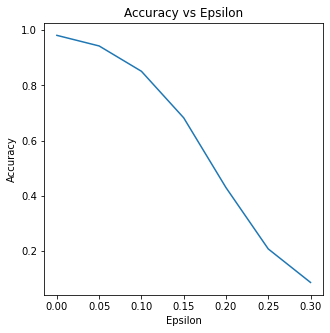

In [96]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.plot(epsilons, accuracies)
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

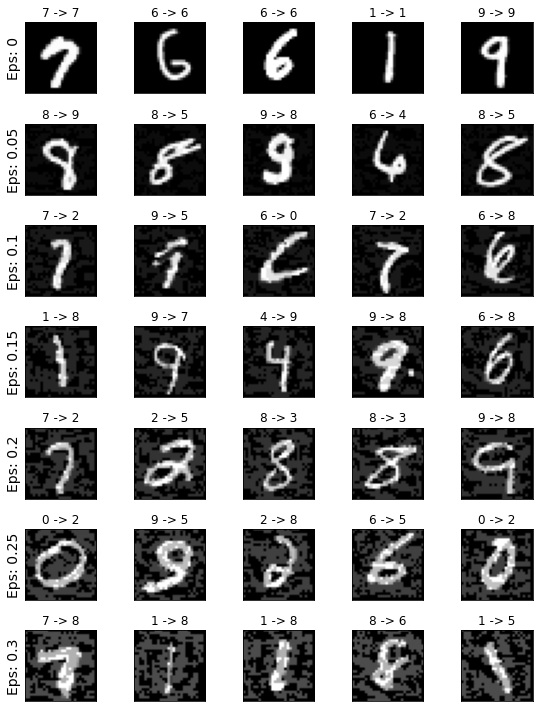

In [97]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()